In [8]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import h5py 
# from sklearn.model_selection import test_test_split
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
import copy 
from scipy.io import savemat

Load dataset

In [2]:
root_out_dir = '../Datasets/mps_gp_sgram/PyData/'
train_dataset = h5py.File(root_out_dir + 'dsMPS_data_train_file.h5', "r")
print(f"keys={train_dataset.keys()}")

# print(train_dataset)
X_train = np.array(train_dataset["data_dsMPS_x"][:]) # your train set features
y_train = to_categorical(np.ravel(np.array(train_dataset["data_label_y"][:]))) # your train set labels

# If we want to train using clean calls only, then take the last 1203 points from the training dataset
X_train_clean = X_train[-1203:,:,:]
y_train_clean = y_train[-1203:,:]

test_dataset = h5py.File(root_out_dir + 'dsMPS_data_test_snrInf.h5', "r")
print(test_dataset)
X_test = np.array(test_dataset["data_dsMPS_x"][:]) # your train set features
y_test = to_categorical(np.ravel(np.array(test_dataset["data_label_y"][:]))) # your train set labels

# train_set_x_norm= train_set_x_orig
# nsamples, nx, ny = train_set_x_orig.shape
# standard_scaler = StandardScaler()
# standard_scaler.fit(train_set_x_orig.reshape((nsamples,nx*ny)))
# train_set_x_norm = standard_scaler.transform(train_set_x_orig)

print(f"Type: X_train={type(X_train)}, y_train={type(y_train)}")
print(f"Shapes: X_train={X_train.shape}, y_train={y_train.shape},X_test={X_test.shape}, y_test={y_test.shape}")

unq_vals, unq_counts = np.unique(y_train, return_counts=True)
print(dict(zip(unq_vals,unq_counts)))
# print(X_train)


keys=<KeysViewHDF5 ['data_dsMPS_x', 'data_label_y']>
<HDF5 file "dsMPS_data_test_snrInf.h5" (mode r)>
Type: X_train=<class 'numpy.ndarray'>, y_train=<class 'numpy.ndarray'>
Shapes: X_train=(5410, 80, 69), y_train=(5410, 5),X_test=(402, 80, 69), y_test=(402, 5)
{0.0: 21640, 1.0: 5410}


## Train a CNN  on noisy data 

In [3]:
tf.random.set_seed(1234)  # applied to achieve consistent results

# Define the model 
CNNmodel_noisy = tf.keras.Sequential([
    ## ZeroPadding2D with padding 3, input shape of 80 x 69 x 1
    ## Conv2D with 32 5x5 filters and stride of 1
    ## BatchNormalization for axis 3
    ## ReLU
    ## Max Pooling 2D with default parameters
    ## Flatten layer
    ## Dense layer with 1 unit for output & 'sigmoid' activation            
        
    # YOUR CODE STARTS HERE
    tf.keras.layers.ZeroPadding2D(padding=3,input_shape=(80,69,1)),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(5,5),padding='same', strides=(1,1)),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(units=5, activation='softmax'),
    # YOUR CODE ENDS HERE
    ])

CNNmodel_noisy.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
CNNmodel_noisy.summary()

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)
history_noisy = CNNmodel_noisy.fit(train_dataset, epochs=100, validation_data=test_dataset)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 86, 75, 1)        0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 86, 75, 16)        416       
                                                                 
 batch_normalization (BatchN  (None, 86, 75, 16)       64        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 86, 75, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 43, 37, 16)       0         
 )                                                               
                                                        

## Train a CNN  on clean data 

In [4]:
tf.random.set_seed(1234)  # applied to achieve consistent results

# Define the model 
CNNmodel_clean = tf.keras.Sequential([
    ## ZeroPadding2D with padding 3, input shape of 80 x 69 x 1
    ## Conv2D with 32 5x5 filters and stride of 1
    ## BatchNormalization for axis 3
    ## ReLU
    ## Max Pooling 2D with default parameters
    ## Flatten layer
    ## Dense layer with 1 unit for output & 'sigmoid' activation            
        
    # YOUR CODE STARTS HERE
    tf.keras.layers.ZeroPadding2D(padding=3,input_shape=(80,69,1)),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(5,5),padding='same', strides=(1,1)),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(units=5, activation='softmax'),
    # YOUR CODE ENDS HERE
    ])

CNNmodel_clean.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
CNNmodel_clean.summary()

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_clean, y_train_clean)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)
history_clean = CNNmodel_clean.fit(train_dataset, epochs=100, validation_data=test_dataset)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_1 (ZeroPaddi  (None, 86, 75, 1)        0         
 ng2D)                                                           
                                                                 
 conv2d_1 (Conv2D)           (None, 86, 75, 16)        416       
                                                                 
 batch_normalization_1 (Batc  (None, 86, 75, 16)       64        
 hNormalization)                                                 
                                                                 
 re_lu_1 (ReLU)              (None, 86, 75, 16)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 37, 16)       0         
 2D)                                                             
                                                      

## Check output of NN model 

13/13 [==============================] - 0s 1ms/step
Unique values in y_train_pred_NN=[0 1 2 3 4]
Unique values in y_test_pred_NN=[0 1 2 3 4]
Training accuracy=0.9940850277264325
 Testing accuracy=0.8930348258706468



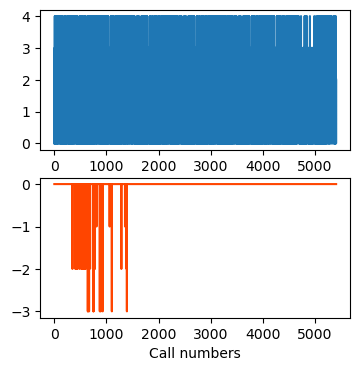

In [5]:
y_train_pred_NN = np.argmax(CNNmodel_noisy.predict(X_train), axis=1)
y_test_pred_NN = np.argmax(CNNmodel_noisy.predict(X_test), axis=1)
y_train_numeric= np.argmax(y_train, axis=1)
y_test_numeric= np.argmax(y_test, axis=1)

print(f"Unique values in y_train_pred_NN={np.unique(y_train_pred_NN)}")
print(f"Unique values in y_test_pred_NN={np.unique(y_test_pred_NN)}")

fig, ax = plt.subplots(2,1,figsize=(4,4))
ax[0].plot(y_train_numeric)
ax[1].plot(y_train_numeric-y_train_pred_NN, color = "orangered")
ax[1].set_xlabel("Call numbers")

print(f"Training accuracy={np.sum(y_train_numeric==y_train_pred_NN)/len(y_train)}\n Testing accuracy={np.sum(y_test_numeric==y_test_pred_NN)/len(y_test_numeric)}\n")

## Test in different SNRs 

../Datasets/mps_gp_sgram/PyData/dsMPS_data_test_snr-20.h5
<HDF5 file "dsMPS_data_test_snr-20.h5" (mode r)>
13/13 [==============================] - 0s 1ms/step
Testing accuracy=0.18159203980099503

../Datasets/mps_gp_sgram/PyData/dsMPS_data_test_snr-15.h5
<HDF5 file "dsMPS_data_test_snr-15.h5" (mode r)>
13/13 [==============================] - 0s 1ms/step
Testing accuracy=0.2562189054726368

../Datasets/mps_gp_sgram/PyData/dsMPS_data_test_snr-10.h5
<HDF5 file "dsMPS_data_test_snr-10.h5" (mode r)>
13/13 [==============================] - 0s 1ms/step
Testing accuracy=0.4129353233830846

../Datasets/mps_gp_sgram/PyData/dsMPS_data_test_snr-5.h5
<HDF5 file "dsMPS_data_test_snr-5.h5" (mode r)>
13/13 [==============================] - 0s 1ms/step
Testing accuracy=0.5447761194029851

../Datasets/mps_gp_sgram/PyData/dsMPS_data_test_snr0.h5
<HDF5 file "dsMPS_data_test_snr0.h5" (mode r)>
13/13 [==============================] - 0s 1ms/step
Testing accuracy=0.664179104477612

../Datasets/mps_gp_sg

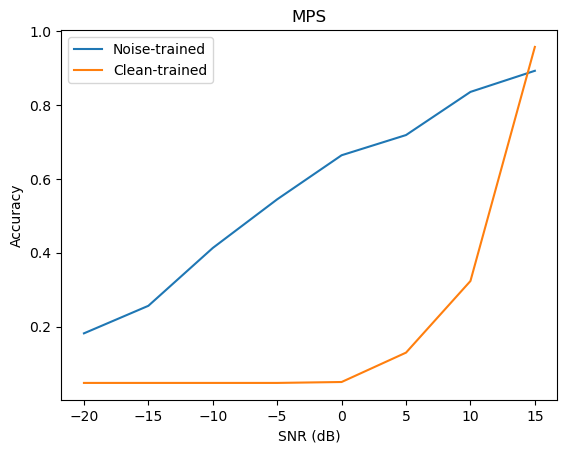

In [6]:
all_snrs= np.arange(-20.0, 11, 5)
all_snrs= np.append(all_snrs, np.inf)

accuracy_vs_snr_noisy = np.zeros((all_snrs.shape))
accuracy_vs_snr_clean = np.zeros((all_snrs.shape))

for snr_value,iter in zip(all_snrs,range(all_snrs.shape[0])):
    if np.isinf(snr_value):
        out_dsMPS_data_test_file= root_out_dir + 'dsMPS_data_test_snrInf.h5'
    else: 
        out_dsMPS_data_test_file= root_out_dir + 'dsMPS_data_test_snr' + str(np.int_(snr_value)) + '.h5'
    print(out_dsMPS_data_test_file)

    test_dataset = h5py.File(out_dsMPS_data_test_file, "r")
    print(test_dataset)
    X_test = np.array(test_dataset["data_dsMPS_x"][:]) # your train set features
    y_test = np.ravel(np.array(test_dataset["data_label_y"][:])) # your train set labels
    y_test_pred_NN_noisy = np.argmax(CNNmodel_noisy.predict(X_test), axis=1)
    y_test_pred_NN_clean = np.argmax(CNNmodel_clean.predict(X_test), axis=1)

    accuracy_vs_snr_noisy[iter] = np.sum(y_test==y_test_pred_NN_noisy)/len(y_test)
    accuracy_vs_snr_clean[iter] = np.sum(y_test==y_test_pred_NN_clean)/len(y_test)
    print(f"Testing accuracy={accuracy_vs_snr_noisy[iter]}\n")

plot_snr= copy.deepcopy(all_snrs)
plot_snr[np.isinf(plot_snr)] = 15
plt.plot(plot_snr, accuracy_vs_snr_noisy, label="Noise-trained")
plt.plot(plot_snr, accuracy_vs_snr_clean, label="Clean-trained")
plt.xlabel("SNR (dB)")
plt.ylabel("Accuracy")
plt.title("MPS")
plt.legend()

In [9]:
out_dsMPS_classify_file = root_out_dir + 'dsMPS_classify_out'
np.savez(out_dsMPS_classify_file + '.npz', all_snrs=all_snrs, accuracy_vs_snr_noisy=accuracy_vs_snr_noisy, accuracy_vs_snr_clean=accuracy_vs_snr_clean)
mat_dict= {"all_snrs":all_snrs, "accuracy_vs_snr_noisy":accuracy_vs_snr_noisy, "accuracy_vs_snr_clean":accuracy_vs_snr_clean}
savemat(out_dsMPS_classify_file + '.mat', mat_dict)